### Diabetic Retinopathy Binary Classification
#### Using transfer learning with the pretrained VGG16 model


## Import Libraries

In [1]:
from PIL import Image
import pathlib
import math
from glob import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Input, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

## Data Preparation

In [2]:
## Load Images from Each Folder
#Reduce Dataset Size by Factor (in case there isn't enough RAM)
ReductionFactor = 10

# Base Path
path = ('../Binary-Diabetic-Retinopathy-Classification/Data/gaussian_filtered_images/')

# Image Reading Function
def read_images(path,num_img):
    array=np.zeros((num_img,224,224,3))
    i=0
    for img in os.listdir(path):
        if (i == num_img):
            break
        img_path=path + "/" + img
        img=Image.open(img_path,mode="r")
        data=np.asarray(img,dtype="uint8")
        array[i]=data
     
        i+=1
    return array

# No DR
noDR_dir = os.path.join(path, 'No_DR')
n_noDR=math.ceil(len(glob(os.path.join(path, 'No_DR/*')))/ReductionFactor)
X_noDR=read_images(noDR_dir,n_noDR)
X_noDR=X_noDR.astype(np.uint8)
print("No DR Shape: ",X_noDR.shape)

# Mild DR
mildDR_dir = os.path.join(path, 'Mild')
n_mildDR=math.ceil(len(glob(os.path.join(path, 'Mild/*')))/ReductionFactor)
X_mildDR=read_images(mildDR_dir,n_mildDR)
X_mildDR=X_mildDR.astype(np.uint8)
print("Mild DR Shape: ",X_mildDR.shape)

# Moderate DR
modDR_dir = os.path.join(path, 'Moderate')
n_modDR=math.ceil(len(glob(os.path.join(path, 'Moderate/*')))/ReductionFactor)
X_modDR=read_images(modDR_dir,n_modDR)
X_modDR=X_modDR.astype(np.uint8)
print("Moderate DR Shape: ",X_modDR.shape)

# Proliferate DR
proDR_dir = os.path.join(path, 'Proliferate_DR')
n_proDR=math.ceil(len(glob(os.path.join(path, 'Proliferate_DR/*')))/ReductionFactor)
X_proDR=read_images(proDR_dir,n_proDR)
X_proDR=X_proDR.astype(np.uint8)
print("Proliferate DR Shape: ",X_proDR.shape)

# Severe DR
sevDR_dir = os.path.join(path, 'Severe')
n_sevDR=math.ceil(len(glob(os.path.join(path, 'Severe/*')))/ReductionFactor)
X_sevDR=read_images(sevDR_dir,n_sevDR)
X_sevDR=X_sevDR.astype(np.uint8)
print("Severe DR Shape: ",X_sevDR.shape)

No DR Shape:  (181, 224, 224, 3)
Mild DR Shape:  (37, 224, 224, 3)
Moderate DR Shape:  (100, 224, 224, 3)
Proliferate DR Shape:  (30, 224, 224, 3)
Severe DR Shape:  (20, 224, 224, 3)


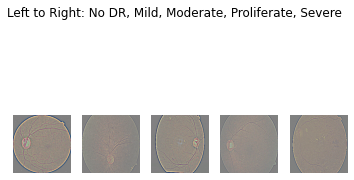

In [3]:
## Show an Image from Each Category
fig=plt.figure()
fig.suptitle('Left to Right: No DR, Mild, Moderate, Proliferate, Severe')

# No DR
fig.add_subplot(1,5,1)
plt.imshow(X_noDR[5])
plt.axis("off")

# Mild DR
fig.add_subplot(1,5,2)
plt.imshow(X_mildDR[5])
plt.axis("off")

# Moderate DR
fig.add_subplot(1,5,3)
plt.imshow(X_modDR[5])
plt.axis("off")

# Proliferate DR
fig.add_subplot(1,5,4)
plt.imshow(X_proDR[5])
plt.axis("off")

# Severe DR
fig.add_subplot(1,5,5)
plt.imshow(X_sevDR[5])
plt.axis("off")

plt.show()

In [4]:
## Combine Arrays to Single X Array
# Concatenate
X=np.concatenate((X_noDR,X_mildDR,X_modDR,X_proDR,X_sevDR),axis=0)
print("X Shape: ",X.shape)

# Delete Arrays to Save RAM
del X_noDR, X_mildDR, X_modDR, X_proDR, X_sevDR

X Shape:  (368, 224, 224, 3)


In [5]:
## Normalise RGB Values to be in Range 0-1
X = X / 255.0

In [6]:
## Create Labels Array Y
# No DR
zeros=np.zeros(n_noDR)

# DR
ones=np.ones(n_mildDR+n_modDR+n_proDR+n_sevDR)

Y = np.concatenate((zeros,ones),axis=0)
print("Y Shape: ",Y.shape)
## Create Class Weights Dict
weights={0: (len(zeros)/(len(zeros)+len(ones))), 1: (len(ones)/(len(zeros)+len(ones)))}

Y Shape:  (368,)


In [7]:
## Shuffle Data
X, Y = shuffle(X, Y)

In [8]:
## Split into Training, Validation and Test (and one-hot-encode labels arrays)
# Split
(X_train, X_TestAndVal, Y_train, Y_TestAndVal) = train_test_split(X, Y, test_size=0.20)
(X_val, X_test, Y_val, Y_test) = train_test_split(X_TestAndVal, Y_TestAndVal, test_size=0.50)
print("X_train Shape: ",X_train.shape)
print("X_val Shape: ",X_val.shape)
print("X_test Shape: ",X_test.shape)

X_train Shape:  (294, 224, 224, 3)
X_val Shape:  (37, 224, 224, 3)
X_test Shape:  (37, 224, 224, 3)


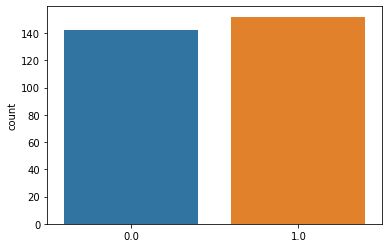

In [9]:
## Show How Many Images of Each Category are in Training Set
sns.countplot(Y_train)

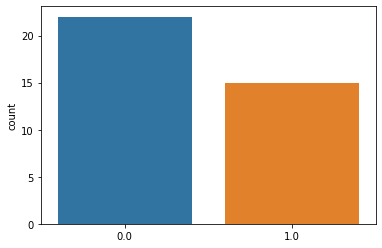

In [10]:
## Show How Many Images of Each Category are in Validation Set
sns.countplot(Y_val)

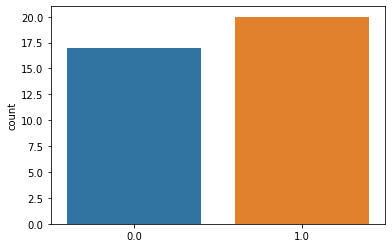

In [11]:
## Show How Many Images of Each Category are in Test Set
sns.countplot(Y_test)

In [12]:
del X, Y, X_TestAndVal, Y_TestAndVal

## Build Model

In [13]:
pretrained_model = VGG16(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights="imagenet")
#pretrained_model.summary()

In [14]:
for layer in pretrained_model.layers[:15]:
    layer.trainable = False
 
for layer in pretrained_model.layers[13:]:
    layer.trainable = True

In [15]:
layer_dict = dict([(layer.name, layer) for layer in pretrained_model.layers])

x = layer_dict['block5_pool'].output

x = Flatten()(x)
#Fully connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
#this is the final layer so the size of output in this layer is equal to the number of class in our problem
x = Dense(1, activation='sigmoid')(x)
#create the new model
custom_model = Model(pretrained_model.input, outputs=x)

In [16]:
custom_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [17]:
custom_model.compile(optimizer='adam', loss = 'BinaryCrossentropy', metrics=['AUC'])

## Train the Trainable Layers

In [18]:
#train the model
History = custom_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=15, class_weight = weights)

Epoch 1/15
10/10 [==============================] - 46s 5s/step - loss: 0.4892 - auc: 0.5496 - val_loss: 0.8017 - val_auc: 0.2333
Epoch 2/15
10/10 [==============================] - 45s 5s/step - loss: 0.3601 - auc: 0.4896 - val_loss: 0.6945 - val_auc: 0.5000
Epoch 3/15
10/10 [==============================] - 45s 4s/step - loss: 0.3467 - auc: 0.4966 - val_loss: 0.6946 - val_auc: 0.5000
Epoch 4/15
10/10 [==============================] - 45s 4s/step - loss: 0.3466 - auc: 0.4960 - val_loss: 0.6961 - val_auc: 0.5000
Epoch 5/15
10/10 [==============================] - 45s 4s/step - loss: 0.3464 - auc: 0.5196 - val_loss: 0.6969 - val_auc: 0.5000
Epoch 6/15
10/10 [==============================] - 45s 4s/step - loss: 0.3463 - auc: 0.5035 - val_loss: 0.6976 - val_auc: 0.5000
Epoch 7/15
10/10 [==============================] - 45s 4s/step - loss: 0.3464 - auc: 0.4838 - val_loss: 0.6993 - val_auc: 0.5000
Epoch 8/15
10/10 [==============================] - 45s 4s/step - loss: 0.3463 - auc: 0.46

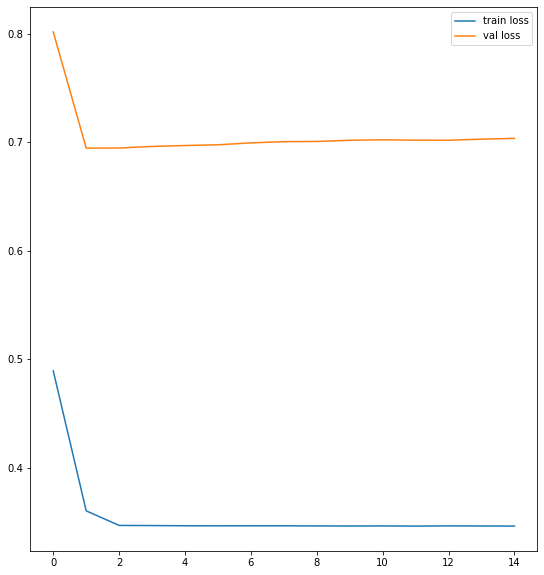

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(History.history["loss"],label="train loss")
plt.plot(History.history["val_loss"],label="val loss")
plt.legend()
plt.show()

KeyError: 'AUC'

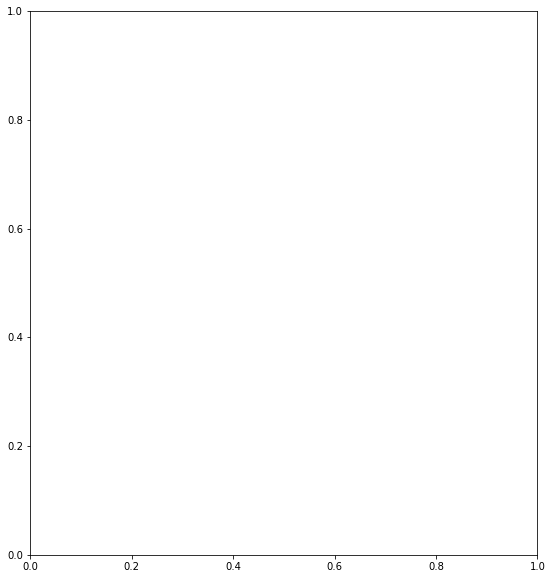

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,2)
plt.plot(History.history["AUC"],label="train AUC")
plt.plot(History.history["val_accuracy"],label="val accuracy")
plt.legend()
plt.show()

# Performance on Test Set

In [21]:
## Test Accuracy
score, acc = custom_model.evaluate(X_test, Y_test,verbose = 0)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.6903886198997498
Test accuracy: 0.5


In [22]:
## Confusion Matrix
predictions = custom_model.predict(X_test)
print(predictions)
print(Y_test)

[[0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]
 [0.52425885]]
[1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.]
